In [1]:
#!/usr/bin/env python

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import torch
import os
import h5py
import numpy as np
import warnings
import time

/home/luchieac/miniconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class ApertureDataset(Dataset):
    """Aperture domain dataset."""

    def __init__(self, fname, num_samples):
        """
        Args:
            fname: file name for aperture domain data
        """

        self.fname = fname
        self.num_samples = num_samples

        # check if files exist
        if not os.path.isfile(fname):
            raise IOError(fname + ' does not exist.')
        
        # Open file
        f = h5py.File(fname, 'r')

        # Get number of samples available for each type
        real_available = f['/4/aperture_data/real'].shape[0]
        imag_available = f['/4/aperture_data/imag'].shape[0]
        samples_available = min(real_available, imag_available)

        # set num_samples
        if not num_samples:
            num_samples = samples_available

        # make sure num_samples is less than samples_available
        if num_samples > samples_available:
            warnings.warn('data_size > self.samples_available. Setting data_size to samples_available')
            self.num_samples = self.samples_available
        else:
            self.num_samples = num_samples

        # load the data
        inputs = np.hstack([ f['/4/aperture_data/real'][0:self.num_samples], 
                            f['/4/aperture_data/imag'][0:self.num_samples] ] )
        targets = np.hstack([ f['/4/targets/real'][0:self.num_samples], 
                            f['/4/targets/imag'][0:self.num_samples] ] )

        # normalize the training data
        C = np.max(np.abs(inputs), axis=1)[:, np.newaxis]
        C[np.where(C==0)[0]] = 1
        inputs = inputs / C
        targets = targets / C

        # convert data to single precision pytorch tensors
        self.data_tensor = torch.from_numpy(inputs).float()
        self.target_tensor = torch.from_numpy(targets).float()

        # close file
        f.close()

    def __len__(self):
        return self.data_tensor.size(0)

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.target_tensor[idx]





class FullyConnectedNet(nn.Module):
    """Fully connected network with. There are five hidden layers.
        ReLU is the activation function. Network parameters are intialized
        with a normal distribution.

    Args:
        input_dim
        output_dim
        layer_width

    """
    def __init__(self, input_dim, output_dim, layer_width):
        #super(FullyConnectedNet, self).__init__()
        super().__init__()

        self.input_layer = nn.Linear(input_dim, layer_width)
        self.hidden_1 = nn.Linear(layer_width, layer_width)
        self.hidden_2 = nn.Linear(layer_width, layer_width)
        self.hidden_3 = nn.Linear(layer_width, layer_width)
        self.hidden_4 = nn.Linear(layer_width, layer_width)
        self.hidden_5 = nn.Linear(layer_width, layer_width)
        self.output_layer = nn.Linear(layer_width, output_dim)
        self.relu = nn.ReLU()

        self._initialize_weights()
	
    def forward(self, x):

        x = self.relu( self.input_layer(x) )
        x = self.relu (self.hidden_1(x) )
        x = self.relu (self.hidden_2(x) )
        x = self.relu (self.hidden_3(x) )
        x = self.relu (self.hidden_4(x) )
        x = self.relu (self.hidden_5(x) )
        x = self.output_layer(x)

        return x

    def _initialize_weights(self):

        nn.init.kaiming_normal( self.input_layer.weight.data )
        self.input_layer.bias.data.fill_(0)

        nn.init.kaiming_normal( self.hidden_1.weight.data )
        self.hidden_1.bias.data.fill_(0)

        nn.init.kaiming_normal( self.hidden_2.weight.data )
        self.hidden_2.bias.data.fill_(0)

        nn.init.kaiming_normal( self.hidden_3.weight.data )
        self.hidden_3.bias.data.fill_(0)

        nn.init.kaiming_normal( self.hidden_4.weight.data )
        self.hidden_4.bias.data.fill_(0)

        nn.init.kaiming_normal( self.hidden_5.weight.data )
        self.hidden_5.bias.data.fill_(0)

        nn.init.kaiming_normal( self.output_layer.weight.data )
        self.output_layer.bias.data.fill_(0)


def lr_finder(model, train_loader, optimizer, loss_fn):
    
    model.train()
    
    # learning rate schedule
    N_steps = len(train_loader)
    lr_sched = lambda step: 10 ** (-6 + step / N_steps * 7)
    scheduler = LambdaLR(optimizer, lr_lambda=[lr_sched])
    
    loss_list = np.zeros(N_steps)
    lr_list = np.zeros(N_steps)
    
    for batch_idx, data in enumerate(train_loader):
        
        scheduler.step(batch_idx)
        lr_list[batch_idx] = optimizer.state_dict()['param_groups'][0]['lr']

        inputs = Variable(data[0])
        targets = Variable(data[1])
        if cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)

        model.zero_grad()

        loss = loss_fn(outputs, targets)

        loss.backward()

        optimizer.step()
        
        loss_list[batch_idx] = loss.data[0]
        
    lr_list = [lr_sched(step) for step in range(N_steps)]
    
    return loss_list, lr_list


    
    


def train(epoch, model, train_loader, loss_fn, optimizer):
    model.train()

    for batch_idx, data in enumerate(train_loader):

        inputs = Variable(data[0])
        targets = Variable(data[1])
        if cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)

        model.zero_grad()

        loss = loss_fn(outputs, targets)

        loss.backward()

        optimizer.step()

def loss_compute(model, dat_loader, loss_fn):
    model.eval()

    loss = 0
    for i, data in enumerate(dat_loader):
        inputs = Variable(data[0])
        targets = Variable(data[1])
        if cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)

        loss = loss + loss_fn(outputs, targets).data[0]

    return loss / len(dat_loader)

In [3]:
# Load primary training data
fname = '../training_data/training_data.h5'
num_samples = 10 ** 5
dat_train = ApertureDataset(fname, num_samples)
train_loader = DataLoader(dat_train, batch_size=1000, shuffle=True, num_workers=1)

# Load secondary training data
fname = '../training_data/training_data.h5'
num_samples = 10 ** 4
dat_train2 = ApertureDataset(fname, num_samples)
train_loader2 = DataLoader(dat_train2, batch_size=1000, shuffle=False, num_workers=1)

# Load validation data
num_samples = 10 ** 4
fname = '../training_data/validation_data.h5'
dat_validate = ApertureDataset(fname, num_samples)
validate_loader = DataLoader(dat_validate, batch_size=1000, shuffle=False, num_workers=1)

# cuda flag
cuda = True
print('torch.cuda.is_available(): ' + str(torch.cuda.is_available()))
if cuda and torch.cuda.is_available():
    print('Using ' + str(torch.cuda.get_device_name(0)))
    cuda = True
else:
    print('Not using CUDA')
    cuda = False

# create model
model = FullyConnectedNet(130, 130, 260)
if cuda:
    model.cuda()

# loss
loss_fn = nn.MSELoss()
if cuda:
    loss_fn = loss_fn.cuda()

torch.cuda.is_available(): True
Using GeForce GTX TITAN X


Text(0.5,0,'lr rate')

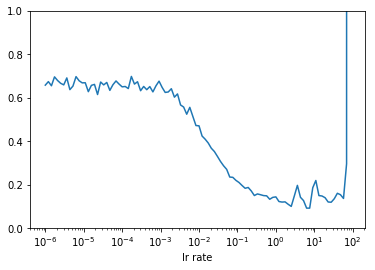

In [4]:
model.train()

# optimizer
lr = 1
momentum = 0
optimizer = optim.SGD(model.parameters(), lr, momentum)

# learning rate schedule
N_steps = len(train_loader)
lr_sched = lambda step: 10 ** (-6 + step / N_steps * 8)
scheduler = LambdaLR(optimizer, lr_lambda=[lr_sched])

loss_list = np.zeros(N_steps)
lr_list = np.zeros(N_steps)

for batch_idx, data in enumerate(train_loader):

    scheduler.step(batch_idx)
    lr_list[batch_idx] = optimizer.state_dict()['param_groups'][0]['lr']

    inputs = Variable(data[0])
    targets = Variable(data[1])
    if cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)

    model.zero_grad()

    loss = loss_fn(outputs, targets)

    loss.backward()

    optimizer.step()

    loss_list[batch_idx] = loss.data[0]

plt.semilogx(lr_list, loss_list)
plt.ylim(0, 1)
plt.xlabel('lr rate')